In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
import math
from scipy.stats import norm

### Question 3

#### (a)

In [8]:
S0 = 100
sigma = 0.3
r = 0.02
c = 0
T = 1
K = 100

In [20]:
def Black_Scholes_Option_Price():
    d1_p1 = math.log(S0/K)+(r-c+math.pow(sigma,2)/2)*T
    d1_p2 = sigma*math.pow(T,0.5)
    d1 = d1_p1 / d1_p2
    d2 = d1 - sigma*math.pow(T,0.5)
    
    price = math.exp(-c*T)*S0*norm.cdf(d1) - math.exp(-r*T)*K*norm.cdf(d2)
    return price

In [21]:
price_BS = Black_Scholes_Option_Price()
print("The prices of European call options in the Black-Schles framework is {:0.2f}.".format(price_BS))

The prices of European call options in the Black-Schles framework is 12.82.


#### (b)

In [22]:
def Binomial_Model_Price(n):
    t = T/n
    u = np.exp(sigma * np.sqrt(t))
    d = 1/u
    p = (np.exp(r * t) - d) / (u - d)

    stock_prices = np.zeros((n, n))
    call_prices = np.zeros((n, n))


    stock_prices[0,0] = S0

    for i in range(1, n):
        M = i + 1
        stock_prices[i, 0] = d * stock_prices[i-1, 0]
        for j in range(1, M ):
            stock_prices[i, j] = u * stock_prices[i - 1, j - 1]

    expiration = stock_prices[-1,:] - K
    expiration.shape = (expiration.size, )
    expiration = np.where(expiration >= 0, expiration, 0)


    call_prices[-1,:] =  expiration

    for i in range(n - 2,-1,-1):
        for j in range(i + 1):
            call_prices[i,j] = np.exp(-r * t) * ((1-p) * call_prices[i+1,j] + p * call_prices[i+1,j+1])

    return call_prices[0,0]

In [32]:
n = 10
price_BM = Binomial_Model_Price(n)
print("The prices of European call options in the Binomial Model is {:0.2f}.".format(price_BM))

The prices of European call options in the Binomial Model is 12.44.


#### (c)

In [33]:
n = [10,25,50,100,600,1000]
price_BM = list(map(Binomial_Model_Price,n))

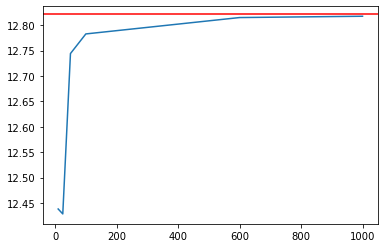

In [35]:
plt.plot(n,price_BM)
plt.axhline(y=price_BS, color='r', linestyle='-')

### Question 4

In [259]:
Stock_price=pd.read_csv('stock_price.csv',index_col=0)

In [260]:
S0 = 100 # Underlying price of stock at t = 0
K = 100 # strike price
r = 0.01 # continuously compounded risk-free interest rate
q = 0.01 # continuously compounded dividend yield
T = 0.5 #  option maturity
N = len(Stock_price.columns)-1 # number of periods

t = 0 # the current time

sigma = 0.4 # implied vol used to generate prices
number_path = len(Stock_price.index)

#### Calcating the C0 (option price at t = 0)

In [261]:
def C_Price(S, K, r, q, T,t,sigma): 
    d1 =  (math.log(S/K) + (r - q + (math.pow(sigma,2))/2)*(T-t)) / (sigma*math.sqrt((T-t)))
    d2 =  d1 - sigma*math.sqrt((T-t))
    C_Price = S * math.exp(-q*(T-t)) *  norm.cdf(d1) - K*math.exp(-r*(T-t))*norm.cdf(d2) # Calculating The Black-Scholes Option Price
    return C_Price
C0 = C_Price(S0, K, r, q,T, t, sigma)
C0

11.190200488459205

#### Creating the delta at each time period baesd on stock price 

In [262]:
def C_Delta(S,index): 
    """
    input: stock price, and the time
    output: delta at time i
    Calculate the delta based on stock price
    """
    ti = 1/N*T*index
    d1  =  (math.log(S/K) + (r + (math.pow(sigma,2))/2)* (T-ti)) / (sigma*math.sqrt(T-ti))
    C_Delta = math.exp(-q*(T-ti)) *  norm.cdf(d1)  # Calculating the delta
    return C_Delta

def return_which_period(value,row):
    row =list(row)
    return row.index(value)

def C_Delta_row(row):
    delta_row = []
    for element in row[:-1]:
        delta_row.append(C_Delta(element,return_which_period(element,row)))
    return delta_row

GBM_Delta = Stock_price.copy().iloc[: , :-1]
for i in range(len(Stock_price.index)):
    GBM_Delta.iloc[i] = C_Delta_row(Stock_price.iloc[i])

#### Calculating the value of portfolio at each time period

In [263]:
# Generate the dataframe to store P, set P0 = C0
P_Delta_Hedgin = Stock_price.copy()
for col in P_Delta_Hedgin.columns:
    P_Delta_Hedgin[col].values[:] = 0

In [264]:
def generate_P_next(P,delta,stock_price,stock_price_next):
    part1 = P
    part2 = (P - delta*stock_price) * r * T/N
    part3 = delta*(stock_price_next + q*stock_price*T/N - stock_price)
    return part1 + part2 + part3

In [265]:
def generate_P_list(P_Delta_Hedgin_list,GBM_Delta_list,Stock_price_list):
    P_list = P_Delta_Hedgin_list
    P_list[0] = C0 
    for i in range(N):
        P_next = generate_P_next(P_list[i],GBM_Delta_list[i],Stock_price_list[i],Stock_price_list[i+1])
        P_list[i+1] = P_next 
    return P_list

for i in range(number_path):
    P_Delta_Hedging_ith_row = P_Delta_Hedgin.iloc[i].to_list()
    GBM_Delta_ith_row = GBM_Delta.iloc[i].to_list()
    Stock_price_ith_row = Stock_price.iloc[i].to_list()
    P_Delta_Hedgin.iloc[i] = generate_P_list(P_Delta_Hedging_ith_row,GBM_Delta_ith_row,Stock_price_ith_row)

In [266]:
def generate_P_and_L(P_Delta_Hedgin_list,GBM_Delta_list,Stock_price_list):
    P_list = generate_P_list(P_Delta_Hedgin_list,GBM_Delta_list,Stock_price_list)
    Pt = P_list[-1]
    St = Stock_price_list[-1]
    PandL = Pt - max(St - K,0)
    return PandL

PandL_list = []
for i in range(number_path):
    P_Delta_Hedging_ith_row = P_Delta_Hedgin.iloc[i].to_list()
    GBM_Delta_ith_row = GBM_Delta.iloc[i].to_list()
    Stock_price_ith_row = Stock_price.iloc[i].to_list()
    PandL = generate_P_and_L(P_Delta_Hedging_ith_row,GBM_Delta_ith_row,Stock_price_ith_row)
    PandL_list.append(PandL)

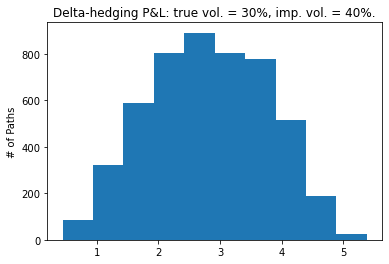

In [268]:
plt.hist(PandL_list)
plt.title("Delta-hedging P&L: true vol. = 30%, imp. vol. = 40%.")
plt.ylabel("# of Paths")
plt.savefig('40%.png', dpi=100)